In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive
!ls

/content/drive/My Drive
 Autoencoder.ipynb	  image_total		     Presentation.pdf
'Colab Notebooks'	 'label info.csv'	     sample_label.CSV
 DL_fp_deeplab-v3.ipynb   ML_fp_v1.ipynb	    'slide from dong.pptx'
 DL_fp_TernausNet.ipynb   ML_fp_v3.ipynb	     test
 DL_fp_Unet.ipynb	  ML_project_v2.ipynb	     train
 DL-HW3.ipynb		  model_paramenter.txt	     Untitled0.ipynb
 DL_HW4.ipynb		  new_test		     Untitled1.ipynb
 evaluate_image		  optimizer_paramenter.txt


In [3]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch
import torch.nn as nn
import numpy as np
import cv2
import random
import torchvision.transforms as transforms
from torch.utils import data
import torchvision
from torch.nn import functional as F
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import numpy as np
import torch.optim as optim
import torchvision.datasets as td
from torchvision import transforms
from PIL import Image
from skimage.feature import hog as hog
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix,f1_score

In [4]:
##label for train,evaluate,test set###  int
ground_truth=[0]*193+[1]*193+[2]*193+[3]*198+[4]*195
evaluate_truth=[0]*3+[1]*3+[2]*3+[3]*3+[4]*3
test_truth=[0]*15+[1]*14+[2]*14+[3]*15+[4]*14

In [16]:
len(test_truth)

72

In [5]:
##load pretrained VGG network ###
VGG=torch.hub.load('pytorch/vision:v0.8.2', 'vgg16', pretrained=True)
#VGG_new=nn.Sequential(*list(VGG.classifier.children())[:-1])
#VGG.classifier=VGG_new
#print(VGG)
VGG_new=nn.Sequential(
    *list(VGG.classifier.children())[:-1],
    nn.Linear(4096,5)
)
VGG.classifier=VGG_new
print(VGG)

Downloading: "https://github.com/pytorch/vision/archive/v0.8.2.zip" to /root/.cache/torch/hub/v0.8.2.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
###make a test###
for p in VGG.features.children():
  for params in p.parameters():
    params.requires_grad=False

for name, params in VGG.named_parameters():
  if params.requires_grad:
    print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [7]:
###define a train loader###
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class train_set(data.Dataset):
  def __init__ (self,root_path='/content/drive/My Drive'):
    self.image=[]
    self.label=ground_truth

    for i in range(1,973):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "image_total", "%07d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=float(self.label[index])
     #pil_image=Image.fromarray(image.astype(np.uint8))

     output=preprocess(image)
     return output,label


path='/content/drive/My Drive'
Train_set=train_set(path)

    

    

      
       


In [8]:
len(Train_set)==len(Train_set.image)
Train_set[1][0].shape

torch.Size([3, 224, 224])

In [9]:
###define evaluate_loader###
class evaluate_set(data.Dataset):
  def __init__ (self,root_path='/content/drive/My Drive'):
    self.image=[]
    self.label=evaluate_truth

    for i in range(1,16):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "evaluate_image", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=float(self.label[index])

     output=preprocess(image)
     return output,label
     
path='/content/drive/My Drive'
evaluate_set=evaluate_set(path)

In [10]:
len(evaluate_set)==len(evaluate_set.image)

True

In [11]:
###define test loader###
class test_set(data.Dataset):
  def __init__ (self,root_path='/content/drive/My Drive'):
    self.image=[]
    self.label=test_truth

    for i in range(72):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "new_test", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=float(self.label[index])

     output=preprocess(image)
     return output,label
     
path='/content/drive/My Drive'
test_set=test_set(path)

In [12]:
len(test_set)==len(test_set.image)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


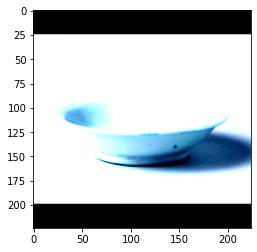

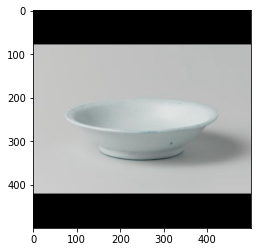

In [13]:
###example of preprocess image and original image###
root_path='/content/drive/My Drive'
image,label=Train_set[1]
print(image.shape)
a=image.squeeze(0).numpy().transpose((1,2,0))
plt.imshow(a)
plt.show()
##(0-255) int###
img = cv2.imread(os.path.join(root_path, "image_total", "%07d.jpg" % 2))
plt.imshow(img)
plt.show()
#a

In [14]:
###create related DataLoader###
train_loader=data.DataLoader(Train_set,batch_size=32,shuffle=True,drop_last=True,num_workers=2)
eva_loader=data.DataLoader(evaluate_set,batch_size=1,num_workers=2)
test_loader=data.DataLoader(test_set,batch_size=1,num_workers=2)

In [15]:
###main train and evaluate function ###
def train_main(model,loss_fn,optimizer,train_loader):
  loss_epoch=[]
  for batchind,data in enumerate(train_loader):
    model.train()
    ##(b,c,h,w)
    images,label=data
    #print(images.shape)
    optimizer.zero_grad()
    outputs=model(images)
    ouputs=outputs.long()
    label=label.long()

    loss=loss_fn(outputs,label)
    loss_epoch.append(loss.item())

    loss.backward()
    optimizer.step()
  return loss_epoch

def evaluate_whole(model,evaluate_loader,evaluate_truth):
  predict_list=[]
  norm=nn.Softmax(1)
  model.eval()
  with torch.no_grad():
    for batchind,data in enumerate(evaluate_loader):
      images,label=data
      ##change to (1,c,h,w)
      images_norm=images
      outputs=model(images_norm)
      norm_outputs=norm(outputs).numpy().ravel()
      predict_list.append(np.argmax(norm_outputs))
  f1_c=f1_score(evaluate_truth,predict_list,average='micro')

  return predict_list,f1_c




num_epoch=3
model=VGG
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=1e-4)


In [16]:
### main train function###
train_loss=[]
evaluate_score=[]
for i in range(num_epoch):
  loss=train_main(model,loss_fn,optimizer,train_loader)
  train_loss.append(np.mean(loss))
  predict_r,f1_r=evaluate_whole(model,eva_loader,evaluate_truth)
  evaluate_score.append(f1_r)
  print(f'epoch{i+1} has been trained')





epoch1 has been trained
epoch2 has been trained
epoch3 has been trained


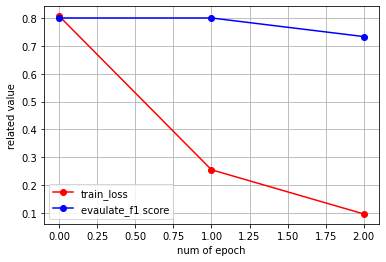

In [18]:
### print train result and evaluation result###
plt.plot(train_loss,'o-r',label='train_loss')
plt.plot(evaluate_score,'o-b',label='evaulate_f1 score')
plt.xlabel('num of epoch')
plt.ylabel('related value')
plt.grid()
plt.legend()
plt.show()

In [19]:
## the main test part ##
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score
def test_whole(model,test_loader,truth_label):
  predict_list=[]
  norm=nn.Softmax(1)
  model.eval()
  with torch.no_grad():
    for batchind,data in enumerate(test_loader):
      images,label=data
      ##change to (1,c,h,w)
      images_norm=images
      outputs=model(images_norm)
      norm_outputs=norm(outputs).numpy().ravel()
      predict_list.append(np.argmax(norm_outputs))
  f1_c=f1_score(truth_label,predict_list,average='micro')
  con_mat=confusion_matrix(truth_label,predict_list)

  return predict_list,f1_c,con_mat

truth=test_set.label
predict_label,f1,mat=test_whole(model,test_loader,truth)



the micro f1 score on test set is 0.7777777777777778


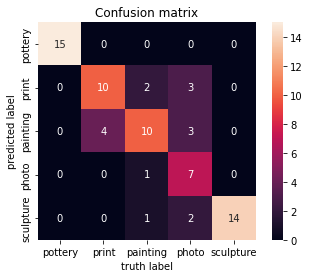

In [20]:
print(f'the micro f1 score on test set is {f1}')
label_name=['pottery','print','painting','photo','sculpture']
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True,xticklabels=label_name,yticklabels=label_name)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix')
plt.show()

In [36]:
###save model's paramenters###
path=os.path.join(root_path,'model_paramenter.txt')
torch.save(model.state_dict(),path)

path2=os.path.join(root_path,'optimizer_paramenter.txt')
torch.save(optimizer.state_dict(),path2)

In [27]:
### create knn data_loader and make related preprocess###
preprocess_knn = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
class train_set_knn(data.Dataset):
  def __init__ (self,root_path='/content/drive/My Drive'):
    self.image=[]
    self.label=ground_truth

    for i in range(1,973):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "image_total", "%07d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=self.label[index]
     #pil_image=Image.fromarray(image.astype(np.uint8))

     return preprocess_knn(image),label

class eva_set_knn(data.Dataset):
  def __init__ (self,root_path='/content/drive/My Drive'):
    self.image=[]
    self.label=evaluate_truth

    for i in range(1,16):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "evaluate_image", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=self.label[index]
     #pil_image=Image.fromarray(image.astype(np.uint8))

     return preprocess_knn(image),label
class test_set_knn(data.Dataset):
  def __init__ (self,root_path='/content/drive/My Drive'):
    self.image=[]
    self.label=test_truth

    for i in range(72):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "new_test", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=self.label[index]
     #pil_image=Image.fromarray(image.astype(np.uint8))

     return preprocess_knn(image),label




In [28]:
##construct 3 dataloader###
knn_train=train_set_knn()
knn_evaluate=eva_set_knn()
knn_test=test_set_knn()

In [29]:
#a=hog(knn_train[1][0],multichannel=True)
#a.shape
c=np.transpose(knn_train[1][0].numpy(),(1,2,0))
type(c)
a=hog(c,multichannel=True)
a.shape
print(len(knn_test)==len(knn_test.label))

True


In [33]:
#len(knn_train.image)==len(knn_train)
#len(knn_test.image)==len(knn_test)
###calculate hog features for KNN###

hog_train=np.zeros((972,54756))
hog_eva=np.zeros((15,54756))
hog_test=np.zeros((72,54756))
knn_train[1][0].shape

for i in range(hog_train.shape[0]):
  hog_train[i,:]=hog(np.transpose(knn_train[i][0].numpy(),(1,2,0)),multichannel=True)

for j in range(hog_eva.shape[0]):
  hog_eva[j,:]=hog(np.transpose(knn_evaluate[j][0].numpy(),(1,2,0)),multichannel=True)

for k in range(hog_test.shape[0]):
  hog_test[k,:]=hog(np.transpose(knn_test[k][0].numpy(),(1,2,0)),multichannel=True)


In [ ]:
hog_eval=np.zeros((45,54756))
for i in range(hog_eval.shape[0]):
  hog_eval[i,:]=hog(np.transpose(knn_train[(i+927)][0].numpy(),(1,2,0)),multichannel=True)

In [ ]:
len([i for i in range(928,973)])
q=[i for i in range(928,973)]
q[-1]
z=[i for i in range(1,21)]
z[1:5]

[2, 3, 4, 5]

the best n_neighbors is 10


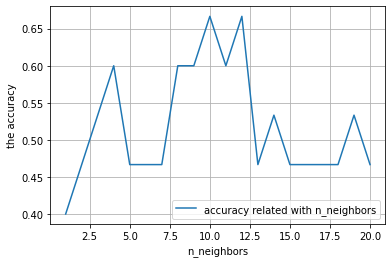

In [34]:
### use evaluate set to find best hyperparameters###
mean_acc=[]
neighbor_list=[i for i in range(1,21)]
target=ground_truth
target_eval=evaluate_truth
for j in neighbor_list:
  KNN_model=KNeighborsClassifier(n_neighbors=j)
  KNN_model.fit(hog_train,target)
  mean_acc.append(KNN_model.score(hog_eva,target_eval))

plt.plot(neighbor_list,mean_acc,label='accuracy related with n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('the accuracy')
plt.grid()
plt.legend()
best_n=neighbor_list[np.argmax(mean_acc)]
print(f'the best n_neighbors is {best_n}')


the micro f1 score on test set is 0.5694444444444444


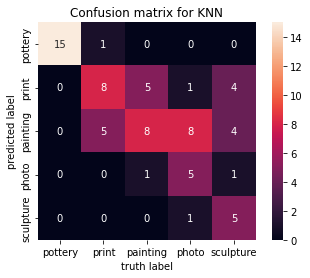

In [35]:
###KNN model performance###
KNN_model=KNeighborsClassifier(n_neighbors=best_n)
KNN_model.fit(hog_train,target)
y_predict=KNN_model.predict(hog_test)

f1_c=f1_score(test_truth,y_predict,average='micro')
con_mat=confusion_matrix(test_truth,y_predict)

print(f'the micro f1 score on test set is {f1_c}')
label_name=['pottery','print','painting','photo','sculpture']
sns.heatmap(con_mat.T,square=True,annot=True,fmt='d',cbar=True,xticklabels=label_name,yticklabels=label_name)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix for KNN')
plt.show()